In [2]:
import tensorflow as tf
from keras import layers
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
)

from keras import Model
from keras.models import Sequential

from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.optimizers import AdamW, RMSprop

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Train data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [5]:
base_model = ResNet50(
    include_top=False, weights="imagenet"
)

for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
model = Sequential(
    [
        layers.Lambda(lambda image: tf.image.resize(image, (224, 224))),
        base_model,
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(10, activation="softmax"),
    ]
)

model.compile(optimizer=RMSprop(0.00003), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
lr_schedule = (
    ReduceLROnPlateau(
        patience=1, factor=0.5, min_lr=1e-6, monitor="val_accuracy", verbose=1
    ),
)

es_res = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True
)

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    callbacks=[es_res, lr_schedule],
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 263s 184ms/step - accuracy: 0.2545 - loss: 2.2686 - val_accuracy: 0.8721 - val_loss: 0.7406 - learning_rate: 2.0000e-05
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 247s 185ms/step - accuracy: 0.5675 - loss: 1.3355 - val_accuracy: 0.9138 - val_loss: 0.4938 - learning_rate: 2.0000e-05
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 185ms/step - accuracy: 0.7137 - loss: 1.0008 - val_accuracy: 0.9343 - val_loss: 0.3649 - learning_rate: 2.0000e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 232s 185ms/step - accuracy: 0.8012 - loss: 0.7755 - val_accuracy: 0.9428 - val_loss: 0.2876 - learning_rate: 2.0000e-05
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 232s 185ms/step - accuracy: 0.8525 - loss: 0.6263 - val_accuracy: 0.9450 - val_loss: 0.2525 - learning_rate: 2.0000e-05
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 185ms/step - accuracy: 0.8901 - loss: 0.5038 - val_accuracy: 0.9497 - val_loss: 0.2171 - learning_rate: 2.0000e-05
Epoch 7/10
1250/1250 ━━━━━━━

In [9]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9506


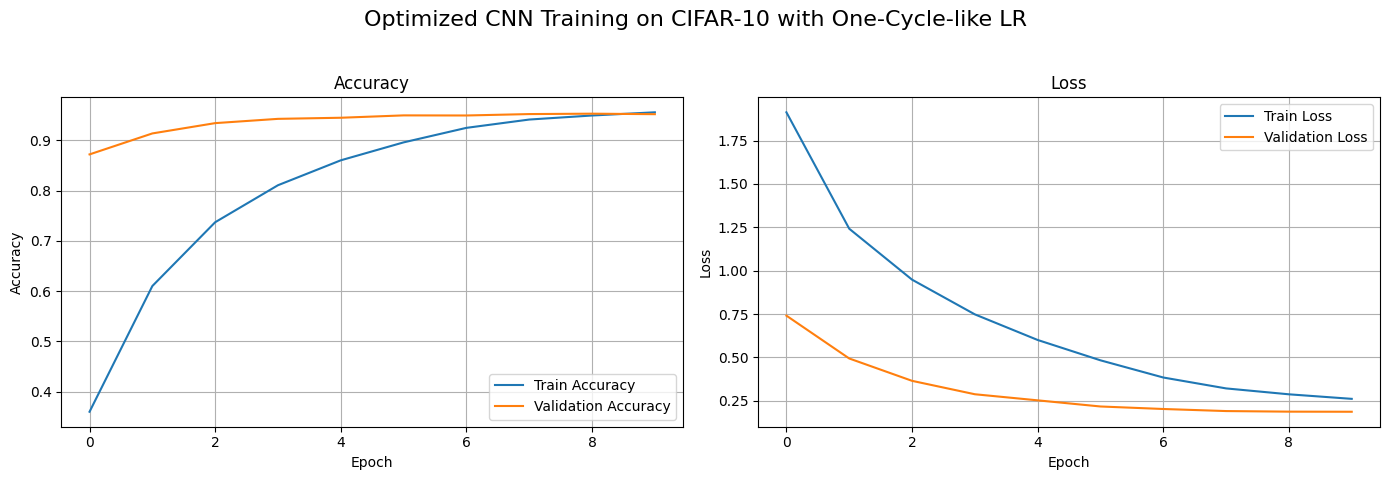

In [10]:
def plot_history(history, title):
    plt.figure(figsize=(14, 5))
    plt.suptitle(title, fontsize=16)

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    if 'lr' in history.history:
        ax2 = plt.gca().twinx()
        ax2.plot(history.history['lr'], color='orange', label='Learning Rate', linestyle=':')
        ax2.set_ylabel('Learning Rate', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        lines, labels = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower right')
    else:
        plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_history(history, "Optimized CNN Training on CIFAR-10 with One-Cycle-like LR")

##  CIFAR-10 Classification: Custom CNN vs ResNet50 (Transfer Learning)

### Dataset: CIFAR-10
- 60,000 images, 10 classes
- Input shape: (32, 32, 3)

---

###  Model 1: Custom CNN from Scratch
- Built using Conv2D, MaxPooling, Dropout, Dense layers
- Fully trained on CIFAR-10 from scratch
- Achieved 87.19% accuracy on test set
- Trained from random weights (no pre-trained features)
- Pros: Lightweight, interpretable
- Cons: Lower accuracy, longer training needed for convergence

---

###  Model 2: ResNet50 (Transfer Learning)
- Pretrained on ImageNet, `include_top=False`
- Added custom classifier head (Learning rate sceduler + Dense + Dropout + Softmax + Early Stopping)
- Froze first 75 layers of total 175 layers
- Fine-tuned remaining 100 layers on CIFAR-10
- Achieved 95.06% accuracy
- Gave higher performance and faster convergence
- It is a fairly heavier model and it required more memory

---

###  Summary Table

| Model             | Accuracy | Frozen Layers | Total Layers | Pretrained | Notes                      |
|------------------|----------|----------------|--------------|------------|----------------------------|
| Custom CNN       | 87.19%   | 0              | Custom       | No       | Trained from scratch       |
| ResNet50 (FT)    | 95.06%   | 75             | 175          | Yes      | Transfer Learning used     |

---

###  Key Takeaways / Learnings & Experience
- Transfer learning with ResNet50 gives a substantial performance boost.
- Freezing lower layers helps retain useful general features while reducing training time.
- Custom models can still perform reasonably well with careful design and tuning.
- Training ResNet50 is time consuming and the method to do the same had to be changed from using two phases to only one phase giving better accuracy comparitively.
